## Imports

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

# cd "drive/MyDrive/Colab_Notebooks/Barbados/Processing/"

# ls

In [ ]:
# !pip install pytz
# !pip install holidays
# !pip install sktime
# !pip install padasip
# !pip install itables
# !pip install plotly
# !pip install matplotlib
# !pip install sklearn
# !pip install keras
# !pip install tensorflow
# !pip install pandas

In [ ]:
import pytz
from datetime import datetime
import pandas as pd
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
import pandas as pd
from itables import show
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, SimpleRNN, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import scipy
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sktime.transformations.series.holiday import HolidayFeatures
from holidays import country_holidays, financial_holidays
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from padasip.filters import FilterRLS
import pickle

## Processing Utils

In [ ]:
filtered_feeders_metadata_file_path = "../Data/Filtered_Feeders_Metadata/Final_Selected_Feeders_Data_with_Coordinates.csv"
feeders_root_path = "./../Data/Feeder_Data"
processed_feeders_root_path = "./../Data/Processed_Feeders"
weather_data_path = "./../Data/Weather_Data/high_resolution_weather_arch_hall.csv"
openmeteo_weather_data_path = "./../Data/Feeder_Weather_Combined_Data"
saved_models_path = "./../Saved_Models"
saved_results_path = "./../Data/Saved_Results"

end_train = "2024-06-16 23:59:59"
end_val = "2024-06-30 23:59:59"
end_test = "2024-07-31 23:59:59"
freq = "h"

weather_columns_to_exclude = {"period"}
# filtered_feature_names = ["air_temp", "dni", "dhi", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high"]
# filtered_feature_names = ["air_temp", "cloud_cover_low"]
# filtered_feature_names = ["temperature_2m", "cloud_cover_low", 'direct_normal_irradiance_instant', 'diffuse_radiation_instant']
filtered_feature_names = ["temperature_2m", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", 'shortwave_radiation']


def remove_dates_from_raw_data(raw_data, dates):
    filtered_data = raw_data.copy()

    for date in dates:
        date = date.strftime("%Y-%m-%d")
        filtered_data = filtered_data.drop(filtered_data.loc[date].index)

    return filtered_data


def remove_nan_days_above_threshold(threshold, raw_data):
    nan_values = raw_data[raw_data["NetLoadDemand"].isna()].fillna(0)
    nan_values = nan_values.groupby(by=nan_values.index.date).count()
    nan_values.index = pd.to_datetime(nan_values.index)
    nan_values.columns = ["Missing_Count"]
    nan_values_filtered = nan_values[nan_values["Missing_Count"] > threshold]
    filtered_data = remove_dates_from_raw_data(raw_data, nan_values_filtered.index)

    return filtered_data, nan_values_filtered


def get_file_from_path_with_name(name, file_path, freq):
    files = os.listdir(file_path)
    print(files)
    filename = [file for file in files if file.startswith(name)]

    raw_data = pd.read_csv(
        os.path.join(file_path, filename[0]),
        na_values=[""],
        skipinitialspace=True,
    ).dropna()

    raw_data["Time"] = raw_data["Time"].drop_duplicates(keep="last")
    raw_data = raw_data.dropna()
    raw_data.set_index("Time", inplace=True, verify_integrity=True)
    raw_data.index = pd.to_datetime(raw_data.index).tz_localize(None)
    raw_data = raw_data.resample(freq).mean()

    return raw_data


def keep_column(column_name):
    return column_name not in weather_columns_to_exclude


def get_weather_data(weather_data_path, openmeteo_weather_data_path, filtered_target_data, filtered_feature_names, freq):
    weather_data = pd.read_csv(weather_data_path, index_col="period_end", parse_dates=True, usecols=keep_column)
    openmeteo_weather_data = pd.read_csv(openmeteo_weather_data_path, index_col="Time")
    openmeteo_weather_data = openmeteo_weather_data.dropna()
    weather_data.index = pd.to_datetime(weather_data.index).tz_localize(None)
    openmeteo_weather_data.index = pd.to_datetime(openmeteo_weather_data.index, dayfirst=True).tz_localize(None)
    weather_data = weather_data.dropna()
    filtered_weather_data = weather_data.loc[filtered_target_data.index]
    openmeteo_weather_data = openmeteo_weather_data.resample(freq).mean()
    filtered_openmeteo_weather_data = openmeteo_weather_data.loc[filtered_target_data.index]

    # combined_weather_data = pd.concat([filtered_weather_data, filtered_openmeteo_weather_data], axis=1)
    # combined_weather_data = combined_weather_data[filtered_feature_names]
    filtered_openmeteo_weather_data = filtered_openmeteo_weather_data[filtered_feature_names]

    return filtered_openmeteo_weather_data

In [ ]:
ls

ahmad_algorithm_4.ipynb


## Data Retreival and Preprocessing

In [ ]:
name = "Sunbury"

raw_target_data = get_file_from_path_with_name(name, feeders_root_path, freq)
filtered_target_data, removed_days = remove_nan_days_above_threshold(16, raw_target_data)
filtered_target_data = filtered_target_data.interpolate(method="time")
filtered_feature_data = get_file_from_path_with_name(name, openmeteo_weather_data_path, freq)
filtered_feature_data = filtered_feature_data.loc[filtered_target_data.index]

px.line(filtered_target_data, y="NetLoadDemand").show()

['Arch Hall_ST2B13.csv', 'Dukes_ST2B15.csv', 'Carlton_CA2B5.csv', 'Chapel Street_TY2B4.csvv', 'Duplicate_Rows', 'Fontabelle 2_TY2B10.csvv', 'Fontabelle 1_TY2B7.csvv', 'D.W.H_TY2B9.csv', 'Green Hill_WA2B6.csv', 'Hanson (Belmont)_BE2B1.csv', 'Holders Hill_WA2B1.csv', 'Mile & A Quarter_ST2B16.csv', 'Ometa Mall_MA2B4.csvv', 'NIS_MA2B2.csvv', 'Marhill St._TY2B8.csv', 'Jackson_WA2B5.csv', 'Holetown (St Thomas)_ST2B11.csv', 'Sam Lords_HA2B5.csv', 'Sandy Lane_ST2B18.csv', 'Swan Street_TY2B6.csvv', 'Seawell_HA2B1.csvv', 'Sunbury_HA2B2.csv', 'Welches_WA2B2.csv']
['Arch_Hall_ST2B13_Weather_Combined_Data.csv', 'Backup', 'Chapel_Street_TY2B4_Weather_Combined_Data.csv', 'Dukes_ST2B15_Weather_Combined_Data.csv', 'Fontabelle_1_TY2B7_Weather_Combined_Data.csv', 'Marhill_St._TY2B8_Weather_Combined_Data.csv', 'Hanson_(Belmont)_BE2B1_Weather_Combined_Data.csv', 'Welches_WA2B2_Weather_Combined_Data.csv', 'Sam_Lords_HA2B5_Weather_Combined_Data.csv', 'Swan_Street_TY2B6_Weather_Combined_Data.csv', 'Ometa_Mall

## Data Transformation Utils

In [ ]:
class TimeBasedFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, end_train_date, end_val_date, end_test_date, start_hour=6, end_hour=20, clf_flag=False):
        self.end_train_date = end_train_date
        self.end_val_date = end_val_date
        self.end_test_date = end_test_date
        self.start_hour = start_hour
        self.end_hour = end_hour
        self.day_of_week_encoder = DayOfWeekOneHotEncoder()
        self.data_splitter = DataSplitter(self.end_train_date, self.end_val_date, self.end_test_date)
        self.clf_flag = clf_flag
        self.holidays_transformer = HolidayFeatures(
            calendar=country_holidays(country="BB"),
            return_categorical=False,
            include_weekend=True,
            return_dummies=True,
            return_indicator=True,
            keep_original_columns=True,
        )

    def fit(self, X, y=None, remainder="passthrough", verbose_feature_names_out=True):
        self.day_of_week_encoder.fit(X, y)
        self.data_splitter.fit(X)
        self.holidays_transformer.fit(X, y)
        return self  # Nothing to fit

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")
        if not isinstance(X.index, pd.DatetimeIndex):
            raise ValueError("X must have a DatetimeIndex")

        y = X.iloc[:, -1]  # y is now a Series
        X = X.iloc[:, :-1]  # X is now a DataFrame without the target

        features = X.columns
        X_transformed = []
        y_transformed = []
        y_transformed_clf = []
        new_indices = []

        # Iterate through the days
        unique_dates = X.index.normalize().unique()

        if self.clf_flag:
            for i in range(2, len(unique_dates)):
                current_date = unique_dates[i]
                previous_date = unique_dates[i - 1]
                day_before_previous_date = unique_dates[i - 2]

                # Filter data for current and previous day
                current_day_mask = (X.index.date == current_date.date()) & (X.index.hour >= self.start_hour) & (X.index.hour <= self.end_hour)
                previous_day_mask = (X.index.date == previous_date.date()) & (X.index.hour >= self.start_hour) & (X.index.hour <= self.end_hour)
                day_before_previous_day_mask = (X.index.date == day_before_previous_date.date()) & (X.index.hour >= self.start_hour) & (X.index.hour <= self.end_hour)

                current_day_data = X[current_day_mask]
                previous_day_data = X[previous_day_mask]
                day_before_previous_day_data = X[day_before_previous_day_mask]

                # Check if there is sufficient data
                expected_hours = (self.end_hour - self.start_hour) + 1

                row_data = []
                # Flatten and combine features
                for feature in features:
                    row_data.extend(previous_day_data[feature].values)
                    row_data.extend(current_day_data[feature].values)

                # Include previous day's target.
                prev_day_target = y[previous_day_mask]
                current_day_target = y[current_day_mask]
                day_before_previous_day_target = y[day_before_previous_day_mask]

                row_data.extend(prev_day_target.values - day_before_previous_day_target.values)
                X_transformed.append(row_data)

                y_transformed.append(current_day_target.values - prev_day_target.values)
                new_indices.append(current_date)
        else:
            for i in range(1, len(unique_dates)):
                current_date = unique_dates[i]
                previous_date = unique_dates[i - 1]

                # Filter data for current and previous day
                current_day_mask = (X.index.date == current_date.date()) & (X.index.hour >= self.start_hour) & (X.index.hour <= self.end_hour)
                previous_day_mask = (X.index.date == previous_date.date()) & (X.index.hour >= self.start_hour) & (X.index.hour <= self.end_hour)

                current_day_data = X[current_day_mask]
                previous_day_data = X[previous_day_mask]

                # Check if there is sufficient data
                expected_hours = (self.end_hour - self.start_hour) + 1

                row_data = []
                # Flatten and combine features
                for feature in features:
                    row_data.extend(previous_day_data[feature].values)
                    row_data.extend(current_day_data[feature].values)

                # Include previous day's target.
                prev_day_target = y[previous_day_mask]
                row_data.extend(prev_day_target.values)

                X_transformed.append(row_data)

                # Prepare target data (current day)
                current_day_target = y[current_day_mask]

                y_transformed.append(current_day_target.values)
                y_transformed_clf.append(current_day_target.values - prev_day_target.values)

                new_indices.append(current_date)

        new_indices = pd.to_datetime(new_indices)
        X_transformed = pd.DataFrame(X_transformed, index=new_indices)
        X_transformed = self.day_of_week_encoder.transform(X_transformed)
        X_transformed = self.holidays_transformer.transform(X_transformed)
        y_transformed = pd.DataFrame(y_transformed, index=new_indices)

        # X_train, X_val, X_test, y_train, y_val, y_test = self.data_splitter.transform(X_transformed, y_transformed)
        X_train, X_val, X_test, _, _, _ = self.data_splitter.transform(X_transformed)
        y_train, y_val, y_test, _, _, _ = self.data_splitter.transform(y_transformed)

        daily_dates = new_indices

        # filtered_target_data.loc[np.isin(filtered_target_data.index.date, y_train.index.date)].index
        flattened_train_dates = y.loc[np.isin(X.index.date, y_train.index.date)].between_time(str(self.start_hour) + ":00", str(self.end_hour) + ":00").index
        # print(flattened_train_dates)
        flattened_val_dates = y.loc[np.isin(X.index.date, y_val.index.date)].between_time(str(self.start_hour) + ":00", str(self.end_hour) + ":00").index
        flattened_test_dates = y.loc[np.isin(X.index.date, y_test.index.date)].between_time(str(self.start_hour) + ":00", str(self.end_hour) + ":00").index

        # return X_train, X_val, X_test, y_train, y_val, y_test, y_train_clf, y_val_clf, y_test_clf
        return X_train, X_val, X_test, y_train, y_val, y_test, daily_dates, flattened_train_dates, flattened_val_dates, flattened_test_dates


class DayOfWeekOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

    def fit(self, X, y=None):
        day_of_week = X.index.dayofweek.values.reshape(-1, 1)
        self.encoder.fit(day_of_week)

        return self

    def transform(self, X, y=None):
        day_of_week = X.index.dayofweek.values.reshape(-1, 1)
        encoded_days = self.encoder.transform(day_of_week)
        encoded_days = pd.DataFrame(
            encoded_days, index=X.index, columns=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        )

        # Check X's shape to determine if it's from TimeBasedFeatureExtractor
        if len(X.shape) > 1:  # if it is an array, then hstack
            # Combine with existing features
            X_combined = pd.concat([X, encoded_days], axis=1)
        else:  # If X is just the indices, no need to combine
            return encoded_days

        return X_combined


# --- Custom Transformer for Data Splitting ---
class DataSplitter(BaseEstimator, TransformerMixin):
    def __init__(self, end_train_date, end_val_date, end_test_date):
        self.end_train_date = pd.to_datetime(end_train_date)
        self.end_val_date = pd.to_datetime(end_val_date)
        self.end_test_date = pd.to_datetime(end_test_date)

    def fit(self, X, y=None):
        return self  # Nothing to fit

    def transform(self, X, y=None):

        # Split the data
        X_train = X[X.index <= self.end_train_date]
        y_train = y[y.index <= self.end_train_date] if y is not None else None

        X_val = X[(X.index > self.end_train_date) & (X.index <= self.end_val_date)]
        y_val = y[(y.index > self.end_train_date) & (y.index <= self.end_val_date)] if y is not None else None

        X_test = X[X.index > self.end_val_date]
        y_test = y[y.index > self.end_val_date] if y is not None else None

        return X_train, X_val, X_test, y_train, y_val, y_test


scaler = ColumnTransformer(
    [
        ("feature_scaler", StandardScaler(), slice(0, -1)),
        ("target_scaler", StandardScaler(), [-1]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=True,
).set_output(transform="pandas")

holidays_transformer = HolidayFeatures(
    calendar=country_holidays(country="BB"),
    return_categorical=True,
    include_weekend=True,
    return_indicator=True,
)

feature_extractor_blf = TimeBasedFeatureExtractor(end_train, end_val, end_test, start_hour=0, end_hour=23)
feature_extractor_clf = TimeBasedFeatureExtractor(end_train, end_val, end_test, start_hour=0, end_hour=23, clf_flag=True)

pipeline_blf = Pipeline(
    [
        ("scaler", scaler),
        ("time_based_feature_extractor", feature_extractor_blf),
    ]
)

pipeline_clf = Pipeline(
    [
        ("scaler", scaler),
        ("time_based_feature_extractor", feature_extractor_clf),
    ]
)

In [ ]:
combined_data = pd.concat([filtered_feature_data, filtered_target_data], axis=1)

first_day = combined_data.index[0].strftime("%Y-%m-%d")
last_day = combined_data.index[-1].strftime("%Y-%m-%d")
first_day_hours = combined_data.loc[first_day].shape[1]
last_day_hours = combined_data.loc[last_day].shape[1]

if last_day_hours != 24:
  combined_data = combined_data.drop(combined_data.loc[last_day].index)

if first_day_hours != 24:
  combined_data = combined_data.drop(combined_data.loc[first_day].index)

combined_data


,NetLoadDemand,temperature_2m,relative_humidity_2m,rain,snowfall,pressure_msl,surface_pressure,wind_speed_10m,wind_direction_10m,shortwave_radiation,...,cloud_cover_low,direct_normal_irradiance,diffuse_radiation,sunshine_duration,temperature_2m_max,temperature_2m_min,is_day,weather_effect,is_holiday,NetLoadDemand
Time,,,,,,,,,,,,,,,,,,,,,
2024-03-17 00:00:00,2347.3525,26.4650,72.5325,0.0,0.0,1014.4750,1009.4025,18.7550,76.4100,0.00,...,25.750,0.0000,0.000,0.0,30.83,26.130,0.0,1.0,0.0,2350.384615
2024-03-17 01:00:00,2235.3350,26.4550,72.7575,0.0,0.0,1013.8750,1008.8050,18.7750,75.3325,0.00,...,20.125,0.0000,0.000,0.0,30.83,26.130,0.0,1.0,0.0,2235.333333
2024-03-17 02:00:00,2190.0825,26.2550,74.0725,0.0,0.0,1013.3900,1008.3150,19.3150,70.6750,0.00,...,16.625,0.0000,0.000,0.0,30.83,26.130,0.0,1.0,0.0,2190.083333
2024-03-17 03:00:00,2133.4175,26.1475,74.6550,0.0,0.0,1013.0500,1007.9800,19.4250,70.2050,0.00,...,17.125,0.0000,0.000,0.0,30.83,26.130,0.0,1.0,0.0,2133.416667
2024-03-17 04:00:00,2105.0825,26.1975,74.2300,0.0,0.0,1012.8750,1007.8050,19.8225,72.0200,0.00,...,17.125,0.0000,0.000,0.0,30.83,26.130,0.0,1.0,0.0,2105.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-30 19:00:00,3167.1650,27.1900,78.4650,0.0,0.0,1014.2250,1009.1625,5.4725,98.5000,3.75,...,6.000,7.7425,3.125,0.0,30.18,25.530,0.0,0.0,0.0,3167.166667
2024-07-30 20:00:00,3184.0000,26.8600,80.3900,0.0,0.0,1015.0500,1009.9800,4.9225,86.6625,0.00,...,3.750,0.0000,0.000,0.0,30.18,25.530,0.0,0.0,0.0,3184.000000
2024-07-30 21:00:00,3081.7500,26.5100,82.0550,0.0,0.0,1015.8375,1010.7600,4.7600,84.4450,0.00,...,0.000,0.0000,0.000,0.0,30.18,25.530,0.0,0.0,0.0,3081.750000


## Data Transformation

In [ ]:


X_train_clf, X_val_clf, X_test_clf, y_train_clf, y_val_clf, y_test_clf, daily_dates, flattened_train_dates, flattened_val_dates, flattened_test_dates = pipeline_clf.fit_transform(combined_data)
X_train, X_val, X_test, y_train, y_val, y_test, daily_dates, flattened_train_dates, flattened_val_dates, flattened_test_dates = pipeline_blf.fit_transform(combined_data)

y_scaler = pipeline_blf.named_steps['scaler'].transformers_[1][1]
y_scaler_clf = pipeline_clf.named_steps['scaler'].transformers_[1][1]

# X_train_blf = X_train.iloc[1:]
X_train_blf = X_train.copy().values
# X_val_blf = X_val.iloc[1:]
# X_test_blf = X_test.iloc[1:]
X_val_blf = X_val.copy().values
X_test_blf = X_test.copy().values


# y_train_blf = y_train.iloc[1:]
y_train_blf = y_train.copy().values
y_val_blf = y_val.copy().values
y_test_blf = y_test.copy().values

# y_val_blf = y_val.iloc[1:]
# y_test_blf = y_test.iloc[1:]

X_train_lstm_blf = X_train_blf.reshape(X_train_blf.shape[0], 1, X_train_blf.shape[1])
X_val_lstm_blf = X_val_blf.reshape(X_val_blf.shape[0], 1, X_val_blf.shape[1])
X_test_lstm_blf = X_test_blf.reshape(X_test_blf.shape[0], 1, X_test_blf.shape[1])

X_train_lstm_clf = X_train_clf.values.reshape(X_train_clf.shape[0], 1, X_train_clf.shape[1])
X_val_lstm_clf = X_val_clf.values.reshape(X_val_clf.shape[0], 1, X_val_clf.shape[1])
X_test_lstm_clf = X_test_clf.values.reshape(X_test_clf.shape[0], 1, X_test_clf.shape[1])

print(X_train_blf.shape, X_val_blf.shape, X_test_blf.shape, X_train_lstm_blf.shape, X_val_lstm_blf.shape, X_test_lstm_blf.shape, y_train_blf.shape, y_val_blf.shape, y_test_blf.shape)
print(X_train_clf.shape, X_val_clf.shape, X_test_clf.shape, X_train_lstm_clf.shape, X_val_lstm_clf.shape, X_test_lstm_clf.shape, y_train_clf.shape, y_val_clf.shape, y_test_clf.shape)

(91, 998) (14, 998) (30, 998) (91, 1, 998) (14, 1, 998) (30, 1, 998) (91, 24) (14, 24) (30, 24)
(90, 998) (14, 998) (30, 998) (90, 1, 998) (14, 1, 998) (30, 1, 998) (90, 24) (14, 24) (30, 24)


In [ ]:
filtered_target_data

,NetLoadDemand
Time,
2024-03-16 16:00:00,1516.100000
2024-03-16 17:00:00,2172.454545
2024-03-16 18:00:00,2658.083333
2024-03-16 19:00:00,2800.833333
2024-03-16 20:00:00,2807.666667
...,...
2024-07-31 19:00:00,3144.166667
2024-07-31 20:00:00,3180.692308
2024-07-31 21:00:00,3076.583333


## Model & Prediction Utils

In [ ]:
def get_flattened_values(y):
    if isinstance(y, pd.DataFrame):
        return y.values.flatten().reshape(-1, 1)
    else:
        return y.flatten().reshape(-1, 1)

def print_metrics(y_true, y_pred, model_type, data_type):
    print("Model: ", model_type)
    print("Data: ", data_type)

    y_true = get_flattened_values(y_true)
    y_pred = get_flattened_values(y_pred)

    print("RMSE: ", root_mean_squared_error(y_true, y_pred))
    print("MAE: ", mean_absolute_error(y_true, y_pred))
    print("MAPE: ", mean_absolute_percentage_error(y_true, y_pred))

def inverse_transform_y(y, scaler):
    y = get_flattened_values(y)

    return scaler.inverse_transform(y).reshape(-1)

def get_results(y, y_pred):
    y = get_flattened_values(y).reshape(-1)
    y_pred = get_flattened_values(y_pred).reshape(-1)

    results = pd.DataFrame({"Actual": y, "Predicted": y_pred})

    return results

def inverse_transform_and_get_results(y, y_pred, y_scaler):
    y_inverse = inverse_transform_y(y, y_scaler)
    y_pred_inverse = inverse_transform_y(y_pred, y_scaler)

    results = get_results(y_inverse, y_pred_inverse)

    return results

def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()

def reshape_sample(original_shape, sample):
    if len(original_shape) == 2:
        return sample.reshape(1, -1)
    elif len(original_shape) == 3:
        return sample.reshape(1, 1, -1)

    return sample

def adapt_rls_combiner_and_predict(results, hours, rls_combiner=None):
    rls_preds = []
    samples = results.shape[0]
    # hours = y.shape[1]

    if not rls_combiner:
        rls_combiner = [FilterRLS(n=results.shape[1] - 1, mu=0.99) for _ in range(hours)]

    for i in range(0, samples, hours):
        for j in range(hours):
            rls_train_sample = [results.iloc[i][col] for col in results.columns[1:]]
            rls_train_sample = np.array(rls_train_sample).reshape(-1)
            rls_actual_sample = results.iloc[i, 0]

            rls_preds_sample = rls_combiner[j].predict(rls_train_sample)
            rls_combiner[j].adapt(rls_actual_sample, rls_train_sample)
            rls_preds.append(rls_preds_sample)

            i += 1

    results["RLS"] = rls_preds
    return results, rls_combiner

def save_rls_combiner(rls_combiner, feeder_name):
    with open(f"{saved_models_path}/RLS_Combiner_Saved_Models/{feeder_name}_rls_combiner.pkl", "wb") as f:
        pickle.dump(rls_combiner, f)


def walk_forward_predict_model(model, X, y, y_scaler, fit_data=True):
    model_preds = []

    samples = X.shape[0]
    hours = y.shape[1]
    original_shape = X.shape


    for i in range(samples):
        X_sample_cur = reshape_sample(original_shape, X[i])
        y_sample_cur = y[i].reshape(1, -1)

        if i > 0 and fit_data:
            model.fit(X_sample_prev, y_sample_prev)

        model_preds_sample = model.predict(X_sample_cur).reshape(-1)
        model_preds.append(model_preds_sample)

        X_sample_prev = X_sample_cur
        y_sample_prev = y_sample_cur

    model_preds = np.array(model_preds)
    model_preds_inverse_flattened = inverse_transform_y(model_preds, y_scaler)

    return model_preds_inverse_flattened

def predict_models_and_combine_results(models_list, X_train_list, X_val_list, X_test_list, y_train_list, y_val_list, y_test_list, y_scaler, model_type_list, flattened_dates_list, feeder_name):
    results_train = []
    results_val = []
    results_test = []
    results_columns = ["Actual"] + model_type_list
    train_dates, val_dates, test_dates = flattened_dates_list
    hours = y_train_list[0].shape[1]

    for i in range(len(models_list)):
        model = models_list[i]
        X_train = X_train_list[i]
        X_val = X_val_list[i]
        X_test = X_test_list[i]
        y_train = y_train_list[i]
        y_val = y_val_list[i]
        y_test = y_test_list[i]
        model_type = model_type_list[i]

        if i == 0:
            y_train_inverse_flattened = inverse_transform_y(y_train, y_scaler)
            y_val_inverse_flattened = inverse_transform_y(y_val, y_scaler)
            y_test_inverse_flattened = inverse_transform_y(y_test, y_scaler)

            results_train.append(y_train_inverse_flattened)
            results_val.append(y_val_inverse_flattened)
            results_test.append(y_test_inverse_flattened)

        y_train_preds = walk_forward_predict_model(model, X_train, y_train, y_scaler, False)
        y_val_preds = walk_forward_predict_model(model, X_val, y_val, y_scaler, True)
        y_test_preds = walk_forward_predict_model(model, X_test, y_test, y_scaler, True)

        print_metrics(y_train, y_train_preds, model_type, "Train")
        print_metrics(y_val, y_val_preds, model_type, "Val")
        print_metrics(y_test, y_test_preds, model_type, "Test")

        results_train.append(y_train_preds)
        results_val.append(y_val_preds)
        results_test.append(y_test_preds)

    results_train = pd.DataFrame(np.array(results_train).T, columns=results_columns, index=train_dates)
    results_val = pd.DataFrame(np.array(results_val).T, columns=results_columns, index=val_dates)
    results_test = pd.DataFrame(np.array(results_test).T, columns=results_columns, index=test_dates)

    # y_train_pred_rls, y_train_pred, rls_combiner = walk_forward_predict_model_and_adapt_rls_combiner(model, X_train, y_train)
    # y_val_pred_rls, y_val_pred, rls_combiner = walk_forward_predict_model_and_adapt_rls_combiner(model, X_val, y_val, rls_combiner)
    # y_test_pred_rls, y_test_pred, rls_combiner = walk_forward_predict_model_and_adapt_rls_combiner(model, X_test, y_test, rls_combiner)

    # print_metrics(y_train, y_train_pred, model_type, "Train")
    # print_metrics(y_val, y_val_pred, model_type, "Val")
    # print_metrics(y_test, y_test_pred, model_type, "Test")

    # print_metrics(y_train, y_train_pred_rls, f"{model_type} RLS", "Train")
    # print_metrics(y_val, y_val_pred_rls, f"{model_type} RLS", "Val")
    # print_metrics(y_test, y_test_pred_rls, f"{model_type} RLS", "Test")

    # results_train = inverse_transform_and_get_results(y_train, y_train_pred, y_scaler)
    # results_val = inverse_transform_and_get_results(y_val, y_val_pred, y_scaler)
    # results_test = inverse_transform_and_get_results(y_test, y_test_pred, y_scaler)

    # results_train_rls = inverse_transform_and_get_results(y_train, y_train_pred_rls, y_scaler)
    # results_val_rls = inverse_transform_and_get_results(y_val, y_val_pred_rls, y_scaler)
    # results_test_rls = inverse_transform_and_get_results(y_test, y_test_pred_rls, y_scaler)

    results_train, rls_combiner_train = adapt_rls_combiner_and_predict(results_train, hours)
    save_rls_combiner(rls_combiner_train, feeder_name)
    results_val, rls_combiner_val = adapt_rls_combiner_and_predict(results_val, hours, rls_combiner_train)
    results_test, rls_combiner_test = adapt_rls_combiner_and_predict(results_test, hours, rls_combiner_val)

    return results_train, results_val, results_test

## ANN, LSTM and LGBM Models

In [ ]:
def train_and_predict_ann_model(X_train, X_val, X_test, y_train, y_val, y_test, model_name, epochs=100, batch_size=1, early_stopping_patience=55, reduce_lr_patience=15, verbose=0, shuffle=False):
    model = Sequential(
        [
            Input(shape=(X_train.shape[1:])),
            Dense(32, activation="relu", kernel_regularizer=l2(0.02)),
            Dropout(0.4),
            Dense(16, activation="relu"),
            Dropout(0.2),
            Dense(16, activation="relu"),
            Dense(y_train.shape[1]),
        ]
    )

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=[MeanAbsoluteError(), RootMeanSquaredError()])

    model.summary()

    early_stopping = EarlyStopping(monitor="val_loss", patience=early_stopping_patience)
    model_checkpoint = ModelCheckpoint(model_name, save_best_only=True, verbose=verbose)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=reduce_lr_patience)

    callbacks = [
        early_stopping,
        model_checkpoint,
        reduce_lr,
    ]

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose,
        shuffle=shuffle
    )

    plot_history(history)

    model = load_model(model_name)
    model.compile(optimizer='rmsprop', loss="mse", metrics=[MeanAbsoluteError(), RootMeanSquaredError()])

    return model

def train_and_predict_lstm_model(X_train, X_val, X_test, y_train, y_val, y_test, model_name, epochs=100, batch_size=1, early_stopping_patience=55, reduce_lr_patience=15, verbose=0, shuffle=False):
    model = Sequential(
        [
            Input(shape=(X_train.shape[1:])),
            LSTM(128, return_sequences=True),
            Dense(16, activation="relu", kernel_regularizer=l2(0.02)),
            Dropout(0.4),
            LSTM(4, return_sequences=False, stateful=False),


            # Dense(64, activation="relu"),
            # Dropout(0.2),
            Dense(15, activation="relu"),
            Dense(y_train.shape[1]),
        ]
    )

    model.compile(optimizer='rmsprop', loss="mse", metrics=[MeanAbsoluteError(), RootMeanSquaredError()])

    model.summary()

    early_stopping = EarlyStopping(monitor="val_loss", patience=early_stopping_patience, verbose=verbose)
    model_checkpoint = ModelCheckpoint(model_name, save_best_only=True, verbose=verbose)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=reduce_lr_patience)

    callbacks = [
        early_stopping,
        model_checkpoint,
        reduce_lr,
    ]

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose,
        shuffle=shuffle
    )

    plot_history(history)

    model = load_model(model_name)
    model.compile(optimizer='rmsprop', loss="mse", metrics=[MeanAbsoluteError(), RootMeanSquaredError()])


    return model

def train_and_predict_lgbm_model(X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    model = MultiOutputRegressor(LGBMRegressor(verbose=1, n_jobs=-1))

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    return y_train_pred, y_val_pred, y_test_pred, model

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                     │ (None, 32)                  │          31,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 24)                  │             408 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,176 (129.59 KB)

 Trainable params: 33,176 (129.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0277 - mean_absolute_error: 0.8604 - root_mean_squared_error: 1.0245
Epoch 1: val_loss improved from inf to 1.24124, saving model to ./../Saved_Models/ANN_Saved_Models/Sunbury_ann_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.0212 - mean_absolute_error: 0.8589 - root_mean_squared_error: 1.0227 - val_loss: 1.2412 - val_mean_absolute_error: 0.6208 - val_root_mean_squared_error: 0.7690 - learning_rate: 0.0010
Epoch 2/300
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3438 - mean_absolute_error: 0.6833 - root_mean_squared_error: 0.8577
Epoch 2: val_loss improved from 1.24124 to 0.79705, saving model to ./../Saved_Models/ANN_Saved_Models/Sunbury_ann_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.3216 - mean_absolute_error: 0.6751 - root_mean_squared_error: 0.8475 - val_loss: 0.7971 - val_mean_absolute_error: 0.4631 - val_root_mean_squared_error: 0.5765 - learning_rate: 0.0010
Epoch 3/300
84/91 ━━━━━

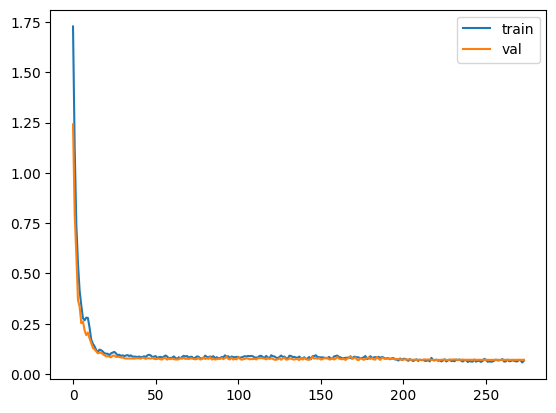

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 1, 128)              │         577,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1, 16)               │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 4)                   │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 15)                  │              75 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 24)                  │             384 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 579,883 (2.21 MB)

 Trainable params: 579,883 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3045 - mean_absolute_error: 0.8057 - root_mean_squared_error: 0.9538
Epoch 1: val_loss improved from inf to 0.72562, saving model to ./../Saved_Models/LSTM_Saved_Models/Sunbury_lstm_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.2994 - mean_absolute_error: 0.8045 - root_mean_squared_error: 0.9524 - val_loss: 0.7256 - val_mean_absolute_error: 0.6377 - val_root_mean_squared_error: 0.7855 - learning_rate: 0.0010
Epoch 2/300
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6311 - mean_absolute_error: 0.5850 - root_mean_squared_error: 0.7424
Epoch 2: val_loss improved from 0.72562 to 0.30311, saving model to ./../Saved_Models/LSTM_Saved_Models/Sunbury_lstm_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6204 - mean_absolute_error: 0.5798 - root_mean_squared_error: 0.7364 - val_loss: 0.3031 - val_mean_absolute_error: 0.3980 - val_root_mean_squared_error: 0.5295 - learning_rate: 0.0010
Epoch 3/300
88/91 ━

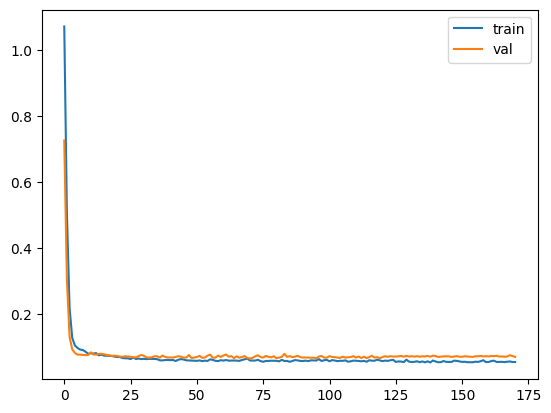

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

In [ ]:
model_ann = train_and_predict_ann_model(X_train_blf, X_val_blf, X_test_blf, y_train_blf, y_val_blf, y_test_blf, f"{saved_models_path}/ANN_Saved_Models/{name}_ann_model.keras", epochs=300, batch_size=1, early_stopping_patience=100, reduce_lr_patience=50, verbose=1, shuffle=False)
# results_train, results_val, results_test, results_train_rls, results_val_rls, results_test_rls = walk_forward_predict_model(model, X_train_blf, X_val_blf, X_test_blf, y_train_blf, y_val_blf, y_test_blf, y_scaler, "ANN")
model_lstm = train_and_predict_lstm_model(X_train_lstm_blf, X_val_lstm_blf, X_test_lstm_blf, y_train_blf, y_val_blf, y_test_blf, f"{saved_models_path}/LSTM_Saved_Models/{name}_lstm_model.keras", epochs=300, batch_size=1, early_stopping_patience=100, reduce_lr_patience=50, verbose=1, shuffle=False)
# results_train_lstm, results_val_lstm, results_test_lstm, results_train_rls_lstm, results_val_rls_lstm, results_test_rls_lstm = walk_forward_predict_model(model, X_train_lstm_blf, X_val_lstm_blf, X_test_lstm_blf, y_train_blf, y_val_blf, y_test_blf, y_scaler, "LSTM")

models_list = [model_ann, model_lstm]
X_train_list = [X_train_blf, X_train_lstm_blf]
X_val_list = [X_val_blf, X_val_lstm_blf]
X_test_list = [X_test_blf, X_test_lstm_blf]
y_train_list = [y_train_blf, y_train_blf]
y_val_list = [y_val_blf, y_val_blf]
y_test_list = [y_test_blf, y_test_blf]
model_type_list = ["ANN", "LSTM"]
flattened_dates_list = [flattened_train_dates, flattened_val_dates, flattened_test_dates]

results_train, results_val, results_test = predict_models_and_combine_results(models_list, X_train_list, X_val_list, X_test_list, y_train_list, y_val_list, y_test_list, y_scaler, model_type_list, flattened_dates_list, name)

# print("ANN Results")
px.line(results_train).show()
px.line(results_val).show()
px.line(results_test).show()

# print("ANN RLS Results")
# px.line(results_train_rls).show()
# px.line(results_val_rls).show()
# px.line(results_test_rls).show()

# print("LSTM Results")
# px.line(results_train_lstm).show()
# px.line(results_val_lstm).show()
# px.line(results_test_lstm).show()

# print("LSTM RLS Results")
# px.line(results_train_rls_lstm).show()
# px.line(results_val_rls_lstm).show()
# px.line(results_test_rls_lstm).show()

In [ ]:
raise ValueError("Stop here")

ValueError: Stop here

In [ ]:
filtered_target_data.loc[np.isin(filtered_target_data.index.date, y_train.index.date)].index

In [ ]:
y_train_pred_ann, y_val_pred_ann, y_test_pred_ann, model, history = train_and_predict_ann_model(X_train_blf, X_val_blf, X_test_blf, y_train_blf, y_val_blf, y_test_blf, "ann_model_blf.h5", epochs=100, batch_size=32, early_stopping_patience=55)
y_train_pred_ann_clf, y_val_pred_ann_clf, y_test_pred_ann_clf, model, history = train_and_predict_ann_model(X_train_clf, X_val_clf, X_test_clf, y_train_clf, y_val_clf, y_test_clf, "ann_model_blf.h5", epochs=100, batch_size=32, early_stopping_patience=55)

print_metrics(y_train_blf, y_train_pred_ann, "ANN", "Base Load Train")
print_metrics(y_val_blf, y_val_pred_ann, "ANN", "Base Load Val")
print_metrics(y_test_blf, y_test_pred_ann, "ANN", "Base Load Test")

results_train_ann = inverse_transform_and_get_results(y_train_blf, y_train_pred_ann, y_scaler)
results_val_ann = inverse_transform_and_get_results(y_val_blf, y_val_pred_ann, y_scaler)
results_test_ann = inverse_transform_and_get_results(y_test_blf, y_test_pred_ann, y_scaler)

px.line(results_train_ann).show()
px.line(results_val_ann).show()
px.line(results_test_ann).show()

In [ ]:
y_train_pred_lstm, y_val_pred_lstm, y_test_pred_lstm, model, history = train_and_predict_lstm_model(X_train_lstm_blf, X_val_lstm_blf, X_test_lstm_blf, y_train_blf, y_val_blf, y_test_blf, "lstm_model_blf.h5", epochs=75, batch_size=8, early_stopping_patience=25)
y_train_pred_lstm_clf, y_val_pred_lstm_clf, y_test_pred_lstm_clf, model, history = train_and_predict_lstm_model(X_train_lstm_clf, X_val_lstm_clf, X_test_lstm_clf, y_train_clf, y_val_clf, y_test_clf, "lstm_model_blf.h5", epochs=75, batch_size=8, early_stopping_patience=25)

print_metrics(y_train_blf, y_train_pred_lstm, "LSTM", "Base Load Train")
print_metrics(y_val_blf, y_val_pred_lstm, "LSTM", "Base Load Val")
print_metrics(y_test_blf, y_test_pred_lstm, "LSTM", "Base Load Test")

results_train_lstm = inverse_transform_and_get_results(y_train_blf, y_train_pred_lstm, y_scaler)
results_val_lstm = inverse_transform_and_get_results(y_val_blf, y_val_pred_lstm, y_scaler)
results_test_lstm = inverse_transform_and_get_results(y_test_blf, y_test_pred_lstm, y_scaler)

px.line(results_train_lstm).show()
px.line(results_val_lstm).show()
px.line(results_test_lstm).show()

In [ ]:
y_train_pred_lgbm, y_val_pred_lgbm, y_test_pred_lgbm, model_lgbm = train_and_predict_lgbm_model(X_train_blf, X_val_blf, X_test_blf, y_train_blf, y_val_blf, y_test_blf, "lgbm_model_blf.h5")
y_train_pred_lgbm_clf, y_val_pred_lgbm_clf, y_test_pred_lgbm_clf, model_lgbm = train_and_predict_lgbm_model(X_train_clf, X_val_clf, X_test_clf, y_train_clf, y_val_clf, y_test_clf, "lgbm_model_blf.h5")

print_metrics(y_train_blf, y_train_pred_lgbm, "LGBM", "Base Load Train")
print_metrics(y_val_blf, y_val_pred_lgbm, "LGBM", "Base Load Val")
print_metrics(y_test_blf, y_test_pred_lgbm, "LGBM", "Base Load Test")

results_train_lgbm = inverse_transform_and_get_results(y_train_blf, y_train_pred_lgbm, y_scaler)
results_val_lgbm = inverse_transform_and_get_results(y_val_blf, y_val_pred_lgbm, y_scaler)
results_test_lgbm = inverse_transform_and_get_results(y_test_blf, y_test_pred_lgbm, y_scaler)

# px.line(results_train_lgbm).show()
# px.line(results_val_lgbm).show()
# px.line(results_test_lgbm).show()

## RLS Utils

In [ ]:
# def plot_history(history):
#     plt.plot(history.history['loss'], label='train')
#     plt.plot(history.history['val_loss'], label='val')
#     plt.legend()
#     plt.show()

# def train_and_predict_ann_model(X_train, X_val, X_test, y_train, y_val, y_test, model_name, epochs=100, batch_size=32, early_stopping_patience=55):
#     model = Sequential(
#         [
#             Input(shape=(X_train.shape[1:])),
#             Dense(128, activation="relu", kernel_regularizer=l2(0.02)),
#             Dropout(0.4),
#             Dense(64, activation="relu"),
#             Dropout(0.2),
#             Dense(64, activation="relu"),
#             Dense(y_train.shape[1]),
#         ]
#     )

#     model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=[MeanAbsoluteError(), RootMeanSquaredError()])

#     model.summary()

#     early_stopping = EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)
#     model_checkpoint = ModelCheckpoint(model_name, save_best_only=True)
#     reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=35)

#     callbacks = [
#         early_stopping,
#         # model_checkpoint,
#         reduce_lr,
#     ]

#     history = model.fit(
#         X_train,
#         y_train,
#         validation_data=(X_val, y_val),
#         epochs=epochs,
#         batch_size=batch_size,
#         callbacks=callbacks,
#         verbose=1,
#     )

#     plot_history(history)

#     # model = load_model(model_name)

#     y_train_pred = model.predict(X_train)
#     y_val_pred = model.predict(X_val)
#     y_test_pred = model.predict(X_test)

#     return y_train_pred, y_val_pred, y_test_pred, model, history

# y_train_pred_ann, y_val_pred_ann, y_test_pred_ann, model, history = train_and_predict_ann_model(X_train, X_val, X_test, y_train, y_val, y_test, "ann_model_blf.h5", epochs=100, batch_size=32, early_stopping_patience=55)
# y_train_pred_ann_clf, y_val_pred_ann_clf, y_test_pred_ann_clf, model, history = train_and_predict_ann_model(X_train, X_val, X_test, y_train_clf, y_val_clf, y_test_clf, "ann_model_blf.h5", epochs=100, batch_size=32, early_stopping_patience=55)

# print("Train: ", root_mean_squared_error(y_train.values.flatten(), y_train_pred_ann.flatten()), mean_absolute_error(y_train.values.flatten(), y_train_pred_ann.flatten()), mean_absolute_percentage_error(y_train.values.flatten(), y_train_pred_ann.flatten()))
# print("Val: ", root_mean_squared_error(y_val.values.flatten(), y_val_pred_ann.flatten()), mean_absolute_error(y_val.values.flatten(), y_val_pred_ann.flatten()), mean_absolute_percentage_error(y_val.values.flatten(), y_val_pred_ann.flatten()))
# print("Test: ", root_mean_squared_error(y_test.values.flatten(), y_test_pred_ann.flatten()), mean_absolute_error(y_test.values.flatten(), y_test_pred_ann.flatten()), mean_absolute_percentage_error(y_test.values.flatten(), y_test_pred_ann.flatten()))


# print("Train CLF: ", root_mean_squared_error(y_train_clf.values.flatten(), y_train_pred_ann_clf.flatten()), mean_absolute_error(y_train_clf.values.flatten(), y_train_pred_ann_clf.flatten()), mean_absolute_percentage_error(y_train_clf.values.flatten(), y_train_pred_ann_clf.flatten()))
# print("Val CLF: ", root_mean_squared_error(y_val_clf.values.flatten(), y_val_pred_ann_clf.flatten()), mean_absolute_error(y_val_clf.values.flatten(), y_val_pred_ann_clf.flatten()), mean_absolute_percentage_error(y_val_clf.values.flatten(), y_val_pred_ann_clf.flatten()))
# print("Test CLF: ", root_mean_squared_error(y_test_clf.values.flatten(), y_test_pred_ann_clf.flatten()), mean_absolute_error(y_test_clf.values.flatten(), y_test_pred_ann_clf.flatten()), mean_absolute_percentage_error(y_test_clf.values.flatten(), y_test_pred_ann_clf.flatten()))

In [ ]:
forget_factor = 0.99
delta = 0.05

rls_combiners_blf = [FilterRLS(n=3, mu=forget_factor, w="random") for _ in range(24)]
rls_combiners_clf = [FilterRLS(n=3, mu=forget_factor, w="random") for _ in range(24)]

def train_and_predict_rls_combiner(actual, actual_clf, pred_ann, pred_lstm, pred_lgbm, pred_ann_clf, pred_lstm_clf, pred_lgbm_clf, rls_combiners_blf, rls_combiners_clf, train_rls=False):
    y_pred_rls_blf = []
    y_pred_rls_clf = []

    for i in range(len(actual)):
        pred_rls_blf_row = []
        pred_rls_clf_row = []

        for j in range(actual.shape[1]):
            combined_preds_blf = np.array([pred_ann[i, j], pred_lstm[i, j], pred_lgbm[i, j]])
            combined_preds_clf = np.array([pred_ann_clf[i, j], pred_lstm_clf[i, j], pred_lgbm_clf[i, j]])

            if train_rls:
                rls_combiners_blf[j].adapt(actual.values[i, j], combined_preds_blf)
                rls_combiners_clf[j].adapt(actual_clf.values[i, j], combined_preds_clf)

            pred_rls_blf_sample = rls_combiners_blf[j].predict(combined_preds_blf)
            pred_rls_clf_sample = rls_combiners_clf[j].predict(combined_preds_clf)

            pred_rls_blf_row.append(pred_rls_blf_sample)
            pred_rls_clf_row.append(pred_rls_clf_sample)

        y_pred_rls_blf.append(pred_rls_blf_row)
        y_pred_rls_clf.append(pred_rls_clf_row)

    return np.array(y_pred_rls_blf), np.array(y_pred_rls_clf)

def reconstruct_from_clf(y_pred_clf, y_pred_blf, train_flag=True):
    if isinstance(y_pred_clf, pd.DataFrame):
        y_pred_clf = y_pred_clf.values
    if isinstance(y_pred_blf, pd.DataFrame):
        y_pred_blf = y_pred_blf.values

    y_pred_reconstructed = np.zeros_like(y_pred_clf)

    if train_flag:
        y_pred_reconstructed[0] = y_pred_blf[0]
    else:
        y_pred_reconstructed[0] = y_pred_blf[-1]

    for i in range(1, y_pred_reconstructed.shape[0]):
        y_pred_reconstructed[i] = y_pred_reconstructed[i - 1] + y_pred_clf[i]
        # print("Row: \n", y_pred_reconstructed[i])

    return y_pred_reconstructed

In [ ]:
# y_val_clf.shape, y_pred_val_rls_clf.shape
y_pred_val_rls_clf

## RLS Train and Predict

In [ ]:
y_pred_train_rls_blf, y_pred_train_rls_clf = train_and_predict_rls_combiner(y_train_blf, y_train_clf, y_train_pred_ann, y_train_pred_lstm, y_train_pred_lgbm, y_train_pred_ann_clf, y_train_pred_lstm_clf, y_train_pred_lgbm_clf, rls_combiners_blf, rls_combiners_clf, train_rls=True)
y_pred_val_rls_blf, y_pred_val_rls_clf = train_and_predict_rls_combiner(y_val_blf, y_val_clf, y_val_pred_ann, y_val_pred_lstm, y_val_pred_lgbm, y_val_pred_ann_clf, y_val_pred_lstm_clf, y_val_pred_lgbm_clf, rls_combiners_blf, rls_combiners_clf)
y_pred_test_rls_blf, y_pred_test_rls_clf = train_and_predict_rls_combiner(y_test_blf, y_test_clf, y_test_pred_ann, y_test_pred_lstm, y_test_pred_lgbm, y_test_pred_ann_clf, y_test_pred_lstm_clf, y_test_pred_lgbm_clf, rls_combiners_blf, rls_combiners_clf)

y_pred_train_rls_blf.shape, y_pred_val_rls_blf.shape, y_pred_test_rls_blf.shape, y_pred_train_rls_clf.shape, y_pred_val_rls_clf.shape, y_pred_test_rls_clf.shape

In [ ]:
y_val_clf[:-1]

In [ ]:
results_train_rls_clf = get_results(y_train_clf, y_pred_train_rls_clf)
results_val_rls_clf = get_results(y_val_clf, y_pred_val_rls_clf)
results_test_rls_clf = get_results(y_test_clf, y_pred_test_rls_clf)

px.line(results_train_rls_clf).show()
px.line(results_val_rls_clf).show()
px.line(results_test_rls_clf).show()

results_train_rls_blf = get_results(y_train_blf, y_pred_train_rls_blf)
results_val_rls_blf = get_results(y_val_blf, y_pred_val_rls_blf)
results_test_rls_blf = get_results(y_test_blf, y_pred_test_rls_blf)

px.line(results_train_rls_blf).show()
px.line(results_val_rls_blf).show()
px.line(results_test_rls_blf).show()

In [ ]:
y_train.values[-1]

In [ ]:
y_val_clf.values[0]

In [ ]:
y_pred_val_rls_clf[0]

In [ ]:
y_train.values[-1] + y_pred_val_rls_clf[0]

In [ ]:
y_val.values[0]

## Reconstruction of Change in Load

In [ ]:
y_train_pred_rls_reconstructed_clf = reconstruct_from_clf(y_pred_train_rls_clf, y_train_blf, train_flag=True)
y_val_pred_rls_reconstructed_clf = reconstruct_from_clf(y_pred_val_rls_clf, y_val_blf, train_flag=True)
y_test_pred_rls_reconstructed_clf = reconstruct_from_clf(y_pred_test_rls_clf, y_test_blf, train_flag=True)

# y_train_pred_rls_reconstructed_clf = reconstruct_from_clf(y_train_clf, y_train_blf, train_flag=True)
# y_val_pred_rls_reconstructed_clf = reconstruct_from_clf(y_val_clf, y_val_blf, train_flag=True)
# y_test_pred_rls_reconstructed_clf = reconstruct_from_clf(y_test_clf, y_test_blf, train_flag=True)

y_train_pred_rls_reconstructed_clf.shape, y_val_pred_rls_reconstructed_clf.shape, y_test_pred_rls_reconstructed_clf.shape

In [ ]:
px.line(y_test_pred_rls_reconstructed_clf.flatten()).show()

In [ ]:
results_train_rls_clf = get_results(y_train_blf, y_train_pred_rls_reconstructed_clf)
results_val_rls_clf = get_results(y_val_blf, y_val_pred_rls_reconstructed_clf)
results_test_rls_clf = get_results(y_test_blf, y_test_pred_rls_reconstructed_clf)

px.line(results_train_rls_clf).show()
px.line(results_val_rls_clf).show()
px.line(results_test_rls_clf).show()

In [ ]:
# testing = np.zeros_like(y_test_clf)
# print(testing[0])
# testing[0] = y_test.values[0]

# for i in range(1, testing.shape[0]):
#     testing[i] = testing[i - 1] + y_test_clf.values[i]

# testing = np.zeros_like(y_test_clf)
# print(testing[0])
# testing[0] = y_test.values[0]

# for i in range(1, testing.shape[0]):
#     testing[i] = testing[i - 1] + y_test_clf.values[i]

# testing = reconstruct_from_clf(y_pred_test_rls_clf, y_pred_test_rls_blf)

px.line(pd.DataFrame([y_train.values.flatten(), y_train_pred_rls_reconstructed_clf.flatten()]).T)

In [ ]:
y_test_rls_reconstructed_clf = reconstruct_from_clf(y_test_clf, y_test)

results_test_rls_reconstructed_clf = pd.DataFrame({"Actual": y_test.values.flatten(), "Predicted": y_test_pred_rls_reconstructed_clf.flatten()})
px.line(results_test_rls_reconstructed_clf).show()

In [ ]:
y_train_inverse = inverse_transform_y(y_train, y_scaler)
y_train_pred_rls_reconstructed_clf_inverse = inverse_transform_y(y_train_pred_rls_reconstructed_clf, y_scaler)

y_val_inverse = inverse_transform_y(y_val, y_scaler)
y_val_pred_rls_reconstructed_clf_inverse = inverse_transform_y(y_val_pred_rls_reconstructed_clf, y_scaler)

y_test_inverse = inverse_transform_y(y_test, y_scaler)
y_test_pred_rls_reconstructed_clf_inverse = inverse_transform_y(y_test_pred_rls_reconstructed_clf, y_scaler)


results_train_rls_reconstructed_clf = pd.DataFrame({"Actual": y_train_inverse, "Predicted": y_train_pred_rls_reconstructed_clf_inverse})
results_val_rls_reconstructed_clf = pd.DataFrame({"Actual": y_val_inverse, "Predicted": y_val_pred_rls_reconstructed_clf_inverse})
results_test_rls_reconstructed_clf = pd.DataFrame({"Actual": y_test_inverse, "Predicted": y_test_pred_rls_reconstructed_clf_inverse})

px.line(results_train_rls_reconstructed_clf).show()
px.line(results_val_rls_reconstructed_clf).show()
px.line(results_test_rls_reconstructed_clf).show()

In [ ]:
results_train_rls = pd.DataFrame({"Actual": y_train.values.flatten(), "Predicted": y_pred_train_rls.flatten()})
results_val_rls = pd.DataFrame({"Actual": y_val.values.flatten(), "Predicted": y_pred_val_rls.flatten()})
results_test_rls = pd.DataFrame({"Actual": y_test.values.flatten(), "Predicted": y_pred_test_rls.flatten()})

results_train_clf_rls = pd.DataFrame({"Actual": y_train_clf.values.flatten(), "Predicted": y_pred_train_clf_rls.flatten()})
results_val_clf_rls = pd.DataFrame({"Actual": y_val_clf.values.flatten(), "Predicted": y_pred_val_clf_rls.flatten()})
results_test_clf_rls = pd.DataFrame({"Actual": y_test_clf.values.flatten(), "Predicted": y_pred_test_clf_rls.flatten()})

px.line(results_train_rls).show()
px.line(results_val_rls).show()
px.line(results_test_rls).show()

px.line(results_train_clf_rls).show()
px.line(results_val_clf_rls).show()
px.line(results_test_clf_rls).show()

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor


model_clf = Sequential()
model_clf.add(Input(shape=(X_train.shape[1:])))
model_clf.add(Dense(256, activation='relu'))
# model_clf.add(Dropout(0.5))
# model_clf.add(Dense(512, activation='relu', kernel_regularizer=l2(0.05)))
model_clf.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
# model_clf.add(Dropout(0.2))
model_clf.add(Dense(32, activation='relu'))
# model_clf.add(Dropout(0.2))
model_clf.add(Dense(y_train_clf.shape[1]))
model_clf.compile(optimizer='rmsprop', loss='mse', metrics=['mae', RootMeanSquaredError()])
model_clf.summary()




callbacks = [
    EarlyStopping(patience=150, verbose=2, restore_best_weights=True),
    # ModelCheckpoint("./../Best_Models/Best_Arch_Model_ANN.keras", save_best_only=True, verbose=2),
    ReduceLROnPlateau(patience=75, factor=0.1, min_lr=1e-7)
]

history = model_clf.fit(X_train, y_train_clf, epochs=100, batch_size=8, validation_data=(X_val, y_val_clf), callbacks=callbacks)
plot_history(history)

model_clf.fit(X_train, y_train_clf)
y_pred_val_clf = model_clf.predict(X_val)
y_pred_test_clf = model_clf.predict(X_test)

print(root_mean_squared_error(y_val_clf.values.flatten(), y_pred_val_clf.flatten()), mean_absolute_error(y_val_clf.values.flatten(), y_pred_val_clf.flatten()), mean_absolute_percentage_error(y_val_clf.values.flatten(), y_pred_val_clf.flatten()))
print(root_mean_squared_error(y_test_clf.values.flatten(), y_pred_test_clf.flatten()), mean_absolute_error(y_test_clf.values.flatten(), y_pred_test_clf.flatten()), mean_absolute_percentage_error(y_test_clf.values.flatten(), y_pred_test_clf.flatten()))

In [ ]:
px.line(pd.DataFrame({"y_val": y_val_clf.values.flatten(), "y_pred_val": y_pred_val_clf.flatten()})).show()
px.line(pd.DataFrame({"y_test": y_test_clf.values.flatten(), "y_pred_test": y_pred_test_clf.flatten()})).show()

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1:])))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae', RootMeanSquaredError()])
model.summary()

def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()


callbacks = [
    EarlyStopping(patience=150, verbose=2, restore_best_weights=True),
    # ModelCheckpoint("./../Best_Models/Best_Arch_Model_ANN.keras", save_best_only=True, verbose=2),
    ReduceLROnPlateau(patience=75, factor=0.1, min_lr=1e-7)
]

history = model.fit(X_train, y_train, epochs=500, batch_size=30, validation_data=(X_val, y_val), callbacks=callbacks)
plot_history(history)
# model = keras.models.load_model("./../Best_Models/Best_Arch_Model_ANN.keras")
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

In [ ]:
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

model = Sequential()
model.add(Input(shape=(X_train.shape[1:])))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.05)))
# model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae', RootMeanSquaredError()])
model.summary()

def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()


callbacks = [
    EarlyStopping(patience=150, verbose=2, restore_best_weights=True),
    # ModelCheckpoint("./../Best_Models/Best_Arch_Model_ANN.keras", save_best_only=True, verbose=2),
    ReduceLROnPlateau(patience=75, factor=0.1, min_lr=1e-7)
]

history = model.fit(X_train, y_train, epochs=500, batch_size=30, validation_data=(X_val, y_val), callbacks=callbacks)
plot_history(history)
# model = keras.models.load_model("./../Best_Models/Best_Arch_Model_ANN.keras")
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

In [ ]:
print(root_mean_squared_error(y_val.values.flatten(), y_pred_val.flatten()), mean_absolute_error(y_val.values.flatten(), y_pred_val.flatten()), mean_absolute_percentage_error(y_val.values.flatten(), y_pred_val.flatten()))
print(root_mean_squared_error(y_test.values.flatten(), y_pred_test.flatten()), mean_absolute_error(y_test.values.flatten(), y_pred_test.flatten()), mean_absolute_percentage_error(y_test.values.flatten(), y_pred_test.flatten()))

In [ ]:
y_scaler = pipeline.named_steps['scaler'].transformers_[1][1]

def inverse_transform_y(y, scaler):
    if isinstance(y, pd.DataFrame):
        y = y.values.flatten().reshape(-1, 1)
    else:
        y = y.flatten().reshape(-1, 1)

    return scaler.inverse_transform(y).reshape(-1)

y_val_inverse = inverse_transform_y(y_val, y_scaler)
y_pred_val_inverse = inverse_transform_y(y_pred_val, y_scaler)

results = pd.DataFrame({
    "Actual": y_val_inverse,
    "Predicted": y_pred_val_inverse
})

px.line(results)

In [ ]:
y_scaler = pipeline.named_steps['scaler'].transformers_[1][1]

def inverse_transform_y(y, scaler):
    if isinstance(y, pd.DataFrame):
        y = y.values.flatten().reshape(-1, 1)
    else:
        y = y.flatten().reshape(-1, 1)

    return scaler.inverse_transform(y).reshape(-1)

y_test_inverse = inverse_transform_y(y_test, y_scaler)
y_pred_test_inverse = inverse_transform_y(y_pred_test, y_scaler)

results = pd.DataFrame({
    "Actual": y_test_inverse,
    "Predicted": y_pred_test_inverse
})

px.line(results)